In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import cm

In [2]:
from math import floor

# Define lattice planes

Only for geometries found in Crystec substrates.

In [3]:
def newCubicPlane(name, a, plane):
    if plane in ("001", "100", "010"):
        return Square(name, a)
    elif plane == "111": # Cubic - 60 deg triangle from 111 
        return Triangle(name, np.sqrt(2) * a)
    elif plane in ("011", "110", "101"): # Rectangular Net
        return RectangleRoot2(name, a)

In [4]:
def newOrthorhombicPlane(name, a, b, c, plane):
    if plane == "001":
        return Rectangle(name, a, b)
    elif plane == "010":
        return Rectangle(name, a, c)
    elif plane == "100":
        return Rectangle(name, b, c)
    elif plane == "110":
        return Rectangle(name, np.hypot(a,b), c)
    elif plane == "101":
        return Rectangle(name, np.hypot(a,c), b)
    elif plane == "011":
        return Rectangle(name, np.hypot(b,c), a)

In [5]:
def newTetragonalPlane(name, a, c, plane):
    if plane == "001":
        return Square(name, a)
    elif plane in ("010", "100"):
        return Rectangle(name, a, c)
    elif plane == "110":
        return Rectangle(name, np.sqrt(2) * a, c)
    elif plane in ("101", "011"):
        return Rectangle(name, a, np.hypot(a,c))

In [6]:
def newHexagonalPlane(name, c, plane):
    if plane == "C":
        return Triangle(name, a)
    elif plane == "A":
        return Rectangle(name, a, np.sqrt(3*a**2 + c**2))
    elif plane == "R":
        return Rectangle(name, c, np.sqrt(3)*a)
    elif plane == "M":
        return Rectangle(name, a, c)

In [7]:
def newPlane(name, structure, a, b, c, plane):
    if structure == "cubic":
        return newCubicPlane(name, a, plane)
    if structure == "orthorhombic":
        return newOrthorhombicPlane(name, a, b, c, plane)
    if structure == "tetragonal":
        return newTetragonalPlane(name, a, c, plane)
    if structure == "hexagonal":
        return newHexagonalPlane(name, a, plane)
    else:
        return None

# Generating superlattices and sublattices

## Set parameters

`MCIA_MAX` sets the absolute max on the superlattice area. `MAX_AXIS_RATIO` restricts how much many unit cells of a film or substrate can be stacked along one axis. `MIN_PARAM` is the minimum length of a unit cell along one axis.

In [8]:
MCIA_MAX = 200    # square angstroms

In [9]:
MIN_PARAM = 3     # angstroms

In [10]:
MAX_AXIS_RATIO = 5

In [11]:
first_few_primes = (2, 3, 5, 7)  # write this at least up to MAX_AXIS_RATIO

## Helper functions

These find superlattices, sublattices, and generate dimension labels.

In [12]:
def formatFraction(numer, denom, sqrt, ax):
    d = "" if denom == 1 else ("/" + str(denom))
    if numer != 1:
        n = str(numer)
    elif sqrt == 1:
        n = ax
    else: n = ""
    s = "" if  sqrt == 1 else ("√" + str(sqrt))
    if ax not in n:
        if denom != 1:
            d += " " + ax
        else:
            d += ax
    return n+s+d

In [13]:
def getSuperlattices(a, b, s):
    area_ratio = MCIA_MAX / (a * b * s)
    const = np.sqrt(s)
    
    superlattices = []
    
    for numer_a in range(1, min(floor(area_ratio)+1, floor(MAX_AXIS_RATIO/const)+1)):
        for numer_b in range(1, min(floor(area_ratio)+1, floor(MAX_AXIS_RATIO/const)+1, floor(area_ratio/numer_a)+1)):
            mcia = numer_a * a * numer_b * b * s
            superlattices.append((numer_a, numer_b, mcia))
    
    return superlattices

In [14]:
def getSublattices(a, b, s, superlattice, isSquare):
    
    const = np.sqrt(s)
    sublattices = []
    numer_a, numer_b, mcia = superlattice
    
    a_primes = [p for p in first_few_primes if numer_a % p == 0]
    b_primes = [p for p in first_few_primes if numer_b % p == 0]
    
    for denom_a in range(1, min(floor(const*a*numer_a/MIN_PARAM)+1, MAX_AXIS_RATIO+1)):
        
        if True in [denom_a % p == 0 for p in a_primes]: continue
        
        for denom_b in range(1, min(floor(const*b*numer_b/MIN_PARAM)+1, MAX_AXIS_RATIO+1)):
            
            if True in [denom_b % p == 0 for p in b_primes]: continue
            
            new_a = a * const * numer_a / denom_a
            new_b = b * const * numer_b / denom_b
            a_frac = formatFraction(numer_a, denom_a, s, "a")
            b_frac = formatFraction(numer_b, denom_b, s, "b")
            label = "(" + a_frac + " × " + b_frac + ")"
            
            sublattices.append([new_a, new_b, label])
            
            if not isSquare:
                label_r = label = "(" + b_frac + " × " + a_frac + ")"
                sublattices.append([new_b, new_a, label_r])
    
    return sublattices

# Geometries

In [15]:
class Rectangle:
    def __init__(self, name: str, a: float, b: float):
        self.name = name
        if a > b: 
            temp = b
            b = a
            a = temp
        self.a = a
        self.b = b
        self.R, self.G, self.B = None, None, None
    
    def __repr__(self):
        return(f"{self.name}\tRectangular net with a = {self.a:.3f}, b = {self.b:.3f}")
    
    def addColor(self, r, g, b):
        self.R, self.G, self.B = r, g, b
    
    def get2DCoords(self):
        """
        Creates a set of lattice parameters that could match to this rectangular substrate.
        """
        
        sqrt = 1
        angle = "0º"
        superlattices = getSuperlattices(self.a, self.b, sqrt)
        sublattices = [(sbl + [spl[2], angle]) for spl in superlattices
                                           for sbl in getSublattices(self.a, self.b, sqrt, spl, False)]
        
        
        df = pd.DataFrame(sublattices, columns = ["a", "b", "dimensions", "mcia", "angle"])
        
        df["substrate"] = self.name
        df["R"], df["G"], df["B"] = self.R, self.G, self.B
        
        return df

In [16]:
class Square:
    def __init__(self, name: str, a: float):
        self.name = name
        self.a = a
        self.R, self.G, self.B = None, None, None
        
    def __repr__(self):
        return(f"{self.name}\tSquare net with a = {self.a:.3f}")
    
    def addColor(self, r, g, b):
        self.R, self.G, self.B = r, g, b
    
    def get2DCoords(self):
        """
        Creates a set of lattice parameters that could match to this square substrate. Allows for rotations.
        """
        
        dataframes = []
        
        sqrts = [1, 2, 5, 10, 13, 17, 26, 29, 34, 37, 41, 53, 58, 61]
        components = [(0,1), (1,1), (1,2), (1,3), (2,3), (1,4), (1,5), (2,5), (3,5), (1,6), (4,5), (2,7), (3,7), (5,6)]
        angles = [np.degrees(np.arctan2(a, b)) for a, b in components]
        angles_str = np.vectorize(lambda x: "{:.1f}º".format(x))(angles)
        
        for (sqrt, angle) in zip(sqrts, angles_str):
            superlattices = getSuperlattices(self.a, self.a, sqrt)
            if superlattices == []: break
            sublattices = [(sbl + [spl[2], angle]) for spl in superlattices
                                           for sbl in getSublattices(self.a, self.a, sqrt, spl, True)]
            
            df = pd.DataFrame(sublattices, columns = ["a", "b", "dimensions", "mcia", "angle"])
            dataframes.append(df)
            
        
        df_final = pd.concat(dataframes).reset_index(drop=True)
        df_final["substrate"] = self.name
        df_final["R"], df_final["G"], df_final["B"] = self.R, self.G, self.B
        
        return df_final

In [17]:
class RectangleRoot2:
    def __init__(self, name, a):
        self.name = name
        self.a = a
        self.R, self.G, self.B = None, None, None

    def __repr__(self):
        return(f"{self.name}\tRectangular net with a = {self.a:.3f}, b = {self.a*np.sqrt(2):.3f}")

    def addColor(self, r, g, b):
        self.R, self.G, self.B = r, g, b
    
    def get2DCoords(self):
        
        dataframes = []
        for (s, angle) in ((1, "0º"), (3, "35.3º")):
            superlattices = getSuperlattices(self.a, self.a*np.sqrt(2), s)
            sublattices = [sbl + [spl[2], angle] for spl in superlattices
                                               for sbl in getSublattices(self.a, self.a*np.sqrt(2), s, spl, False)]
            dataframes.append(pd.DataFrame(sublattices, columns=["a", "b", "dimensions", "mcia", "angle"]))
        
        df_final = pd.concat(dataframes).reset_index(drop=True)

        df_final["substrate"] = self.name
        df_final["R"], df_final["G"], df_final["B"] = self.R, self.G, self.B
        
        return df_final

In [18]:
class Triangle:
    def __init__(self, name, a):
        self.name = name
        self.a = a
        self.R, self.G, self.B = None, None, None

    def __repr__(self):
        return(f"{self.name}\tTriangle net with a = {self.a:.3f}")
    
    def addColor(self, r, g, b):
        self.R, self.G, self.B = r, g, b
    
    def get2DCoords(self):
        r = Rectangle(self.name, self.a, self.a * np.sqrt(3))
        r.addColor(self.R, self.G, self.B)
        df = r.get2DCoords()
        return df

    def get1DCoords(self):
        # Take the unit cell area to be 2 times the simple triangle area. Then Area = (sqrt(3)*a^2)/2
        unit_area = np.sqrt(3) * self.a**2 / 4
        
        sublattices = []
        
        for (sqrt, angle) in zip([1, 3, 7, 13], ["0º", "30º", "19.1º", "13.9º"]):
            area = unit_area * sqrt
            for numer in range(1, floor(np.sqrt(MCIA_MAX / area))+1):
                mcia = numer**2 * area
                for denom in range(1, min(floor(np.sqrt(sqrt)*self.a*numer/MIN_PARAM)+1, MAX_AXIS_RATIO+1)):
                    if True in [denom % p == 0 and numer % p == 0 for p in first_few_primes]: continue
                    label = formatFraction(numer, denom, sqrt, "a")
                    sublattices.append((np.sqrt(sqrt)*self.a*numer/denom, label, mcia, angle))
        
        df = pd.DataFrame(sublattices, columns=["a", "dimensions", "mcia", "angle"])
        df["substrate"] = self.name
        df["R"], df["G"], df["B"] = self.R, self.G, self.B

        return df

# Pull data from CSV file

Just Crystec for now.

In [28]:
crystec = pd.read_csv("./crystec.csv")

In [29]:
crystec

,Name,Structure,Plane,a,b,c
0,Silicon,cubic,"110, 111",5.430,NaN,NaN
1,Germanium,cubic,"100, 111",5.650,NaN,NaN
2,GaAs,cubic,"100, 111, 110",5.650,NaN,NaN
3,GaP,cubic,"100, 111, 110",5.450,NaN,NaN
4,GaSb,cubic,"100, 111, 110",6.090,NaN,NaN
5,InAs,cubic,"100, 111, 110",6.060,NaN,NaN
6,InP,cubic,"100, 111, 110",5.870,NaN,NaN
7,InSb,cubic,"100, 111, 110",6.480,NaN,NaN
8,ZnS,cubic,"100, 111, 110",5.410,NaN,NaN
9,ZnSe,cubic,"100, 111, 110",5.670,NaN,NaN


In [30]:
crystec.drop([11, 12, 21, 22], inplace=True)

In [31]:
substrateDf = crystec

# Generate Substrate List

In [32]:
planes = []

for ind in substrateDf.index:
    structure = substrateDf["Structure"][ind]
    a, b, c = substrateDf["a"][ind], substrateDf["b"][ind], substrateDf["c"][ind]
    for plane in substrateDf["Plane"][ind].split(", "):
        name = substrateDf["Name"][ind] + " (" + plane + ")"
        p = newPlane(name, structure, a, b, c, plane)
        if p is not None:
            planes.append(p)

## Generate colormap

In [33]:
cmap = cm.get_cmap('hsv')

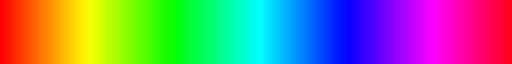

In [34]:
cmap

In [35]:
num_planes = len(planes)
for i in range(num_planes):
    percent = i / num_planes
    r, g, b, a = cmap(percent)
    planes[i].addColor(r, g, b)

In [36]:
triangles = [p for p in planes if isinstance(p, Triangle)]

# Create CSV file

In [44]:
sublattices_2d[]

,a,b,dimensions,mcia,angle,substrate,R,G,B,color_column
0,5.430000,7.679180,(a × b),41.697945,0º,Silicon (110),1.0,0.0,0.000000,"rgb(255.00, 0.00, 0.00)"
1,7.679180,5.430000,(b × a),41.697945,0º,Silicon (110),1.0,0.0,0.000000,"rgb(255.00, 0.00, 0.00)"
2,5.430000,3.839590,(a × b/2),41.697945,0º,Silicon (110),1.0,0.0,0.000000,"rgb(255.00, 0.00, 0.00)"
3,3.839590,5.430000,(b/2 × a),41.697945,0º,Silicon (110),1.0,0.0,0.000000,"rgb(255.00, 0.00, 0.00)"
4,5.430000,15.358359,(a × 2b),83.395891,0º,Silicon (110),1.0,0.0,0.000000,"rgb(255.00, 0.00, 0.00)"
...,...,...,...,...,...,...,...,...,...,...
7196,6.907561,3.256256,(√3/2 b × √3/3 a),134.956703,35.3º,NaCl (110),1.0,0.0,0.140074,"rgb(255.00, 0.00, 35.72)"
7197,3.256256,4.605041,(√3/3 a × √3/3 b),134.956703,35.3º,NaCl (110),1.0,0.0,0.140074,"rgb(255.00, 0.00, 35.72)"
7198,4.605041,3.256256,(√3/3 b × √3/3 a),134.956703,35.3º,NaCl (110),1.0,0.0,0.140074,"rgb(255.00, 0.00, 35.72)"
7199,3.256256,3.453781,(√3/3 a × √3/4 b),134.956703,35.3º,NaCl (110),1.0,0.0,0.140074,"rgb(255.00, 0.00, 35.72)"


In [45]:
def strRep2d(color):
    return (255*sublattices_2d[color]).map('{:,.2f}'.format)
def strRep1d(color):
    return (255*sublattices_1d[color]).map('{:,.2f}'.format)

In [46]:
sublattices_2d = pd.concat([p.get2DCoords() for p in planes]).reset_index(drop=True)
sublattices_2d["color_column"] = "rgb(" + strRep2d("R") + ", " + strRep2d("G") + ", " + strRep2d("B") + ")"

In [47]:
sublattices_1d = pd.concat([t.get1DCoords() for t in triangles]).reset_index(drop=True)
sublattices_1d["color_column"] = "rgb(" + strRep1d("R") + ", " + strRep1d("G") + ", " + strRep1d("B") + ")"

In [48]:
sublattices_2d.to_csv("sublattices_2d.csv", index=False)
sublattices_1d.to_csv("sublattices_1d.csv", index=False)